<a href="https://colab.research.google.com/github/mlinardi91/PES_UTN/blob/main/Ecualizador_de_audio_Etapa_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydub scipy numpy

Revision 3 del proyecto final para la materia Procesamiento embebido de señales

Linardi Marcos A.

Leiva Sergio J.

2024

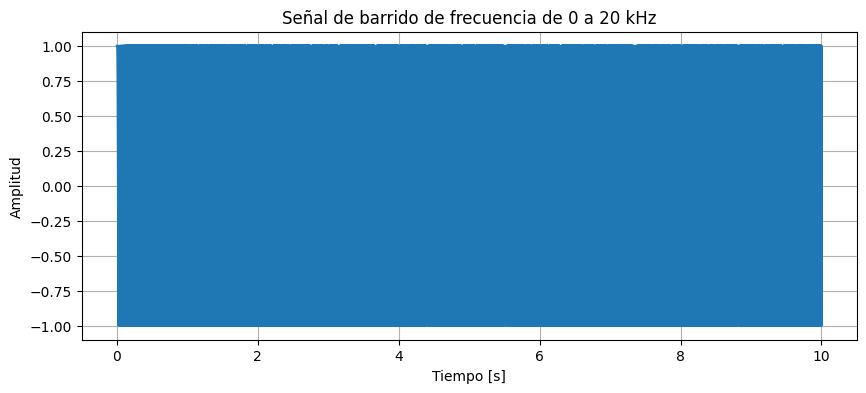

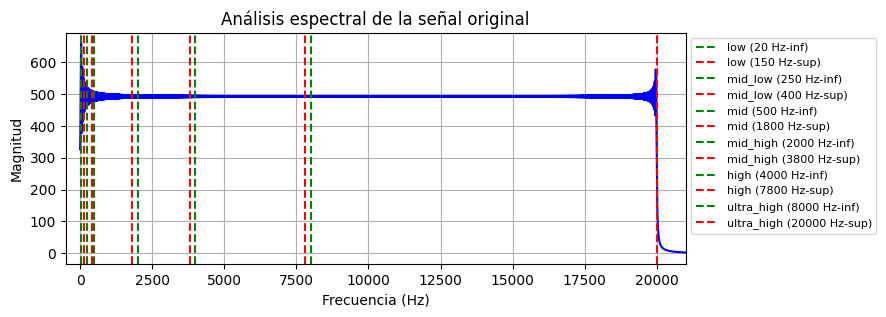

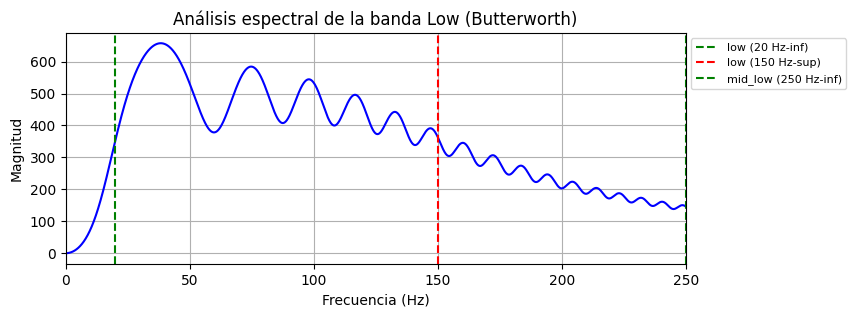

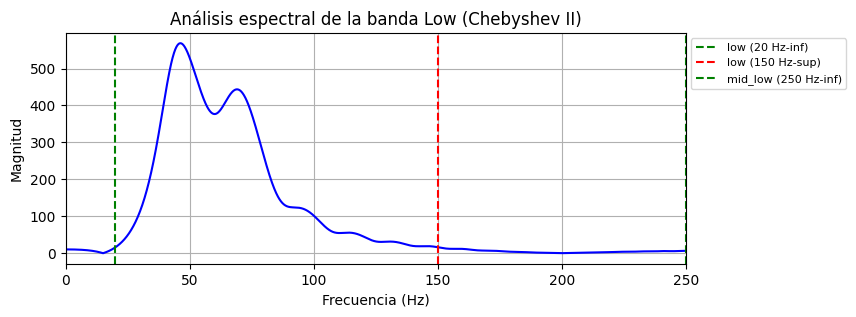

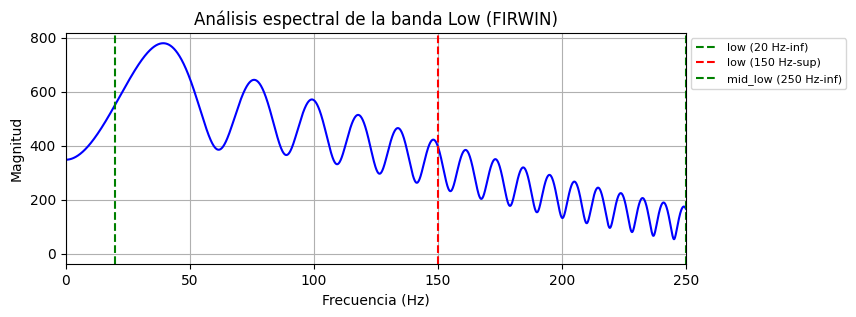

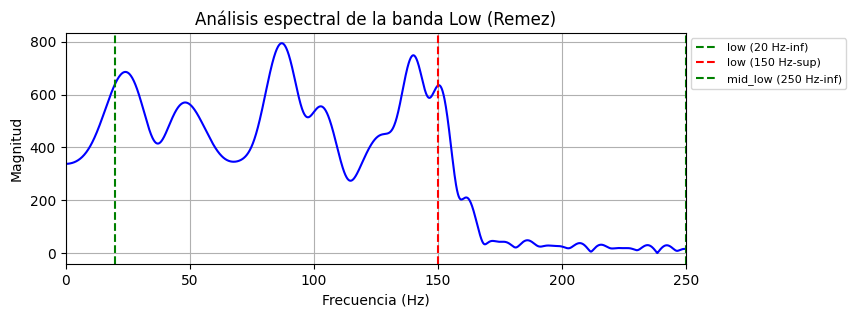

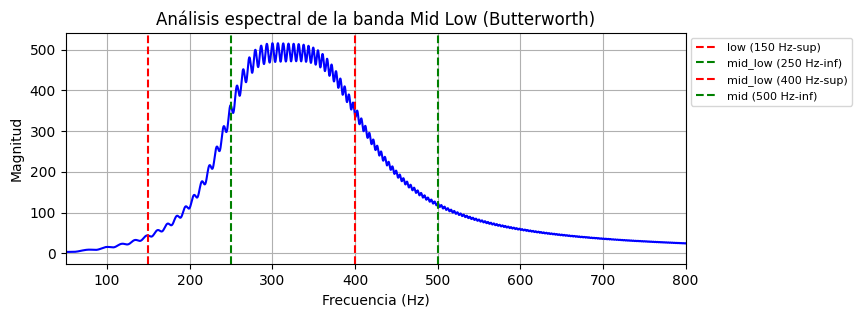

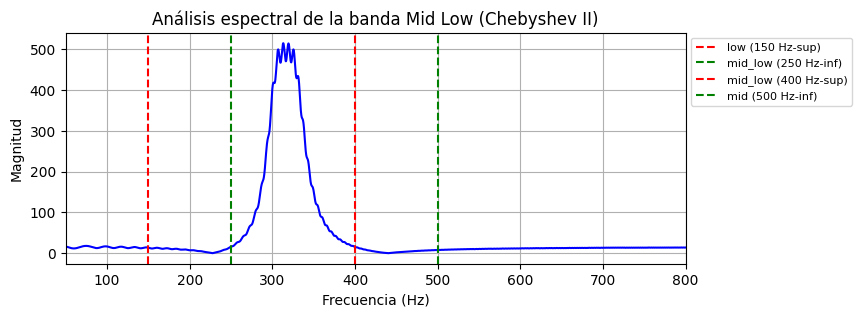

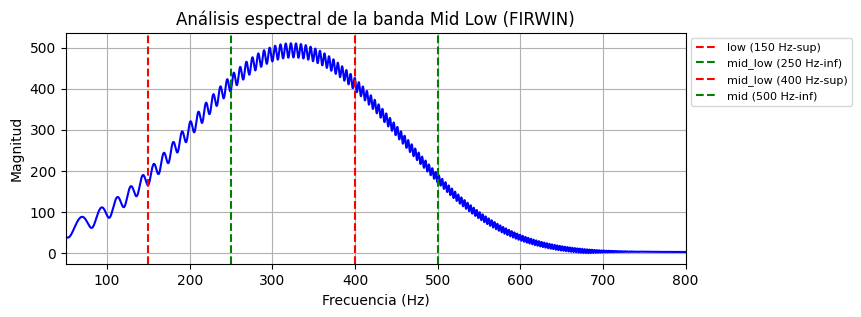

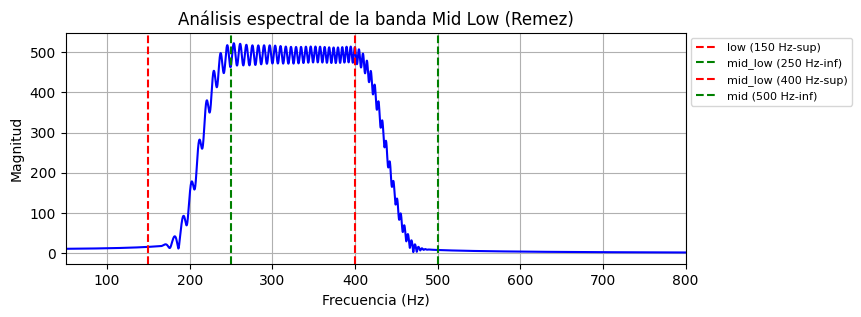

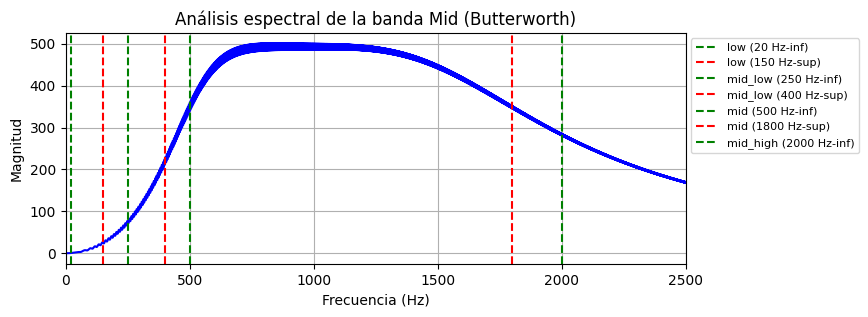

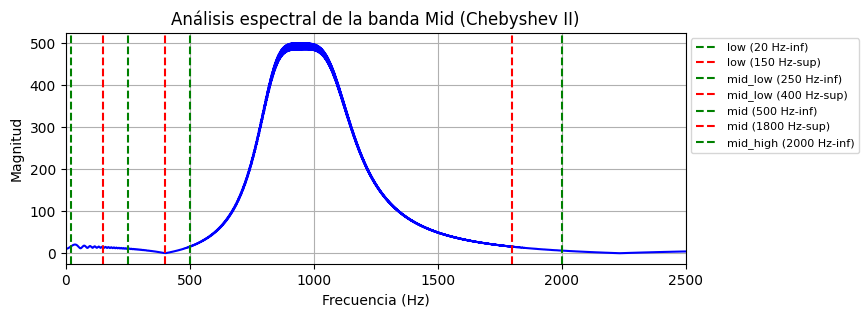

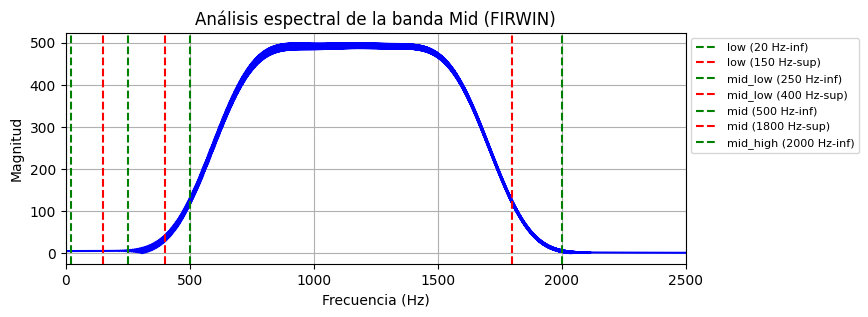

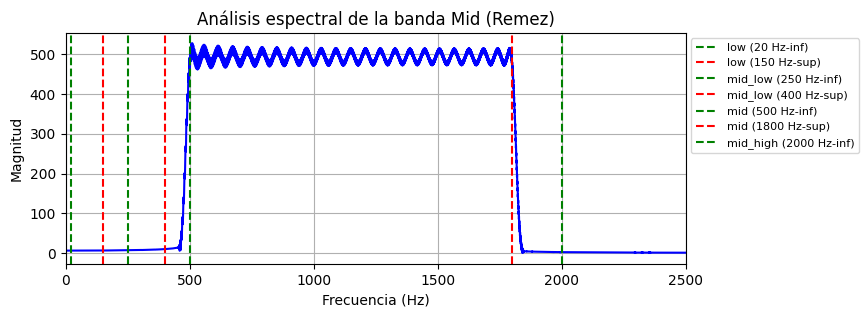

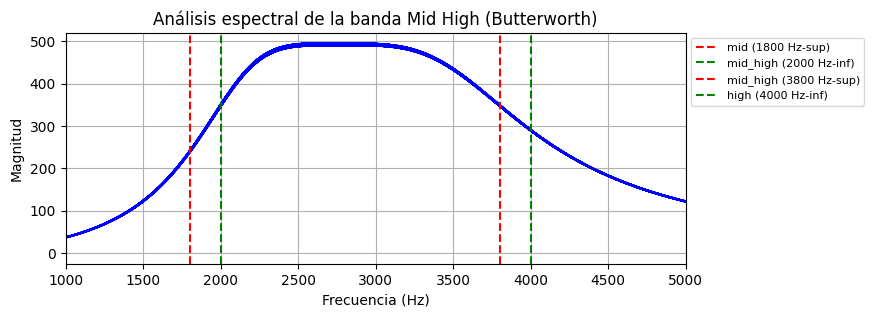

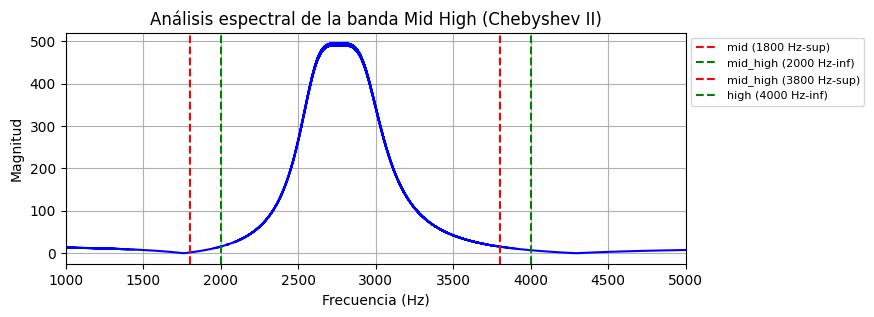

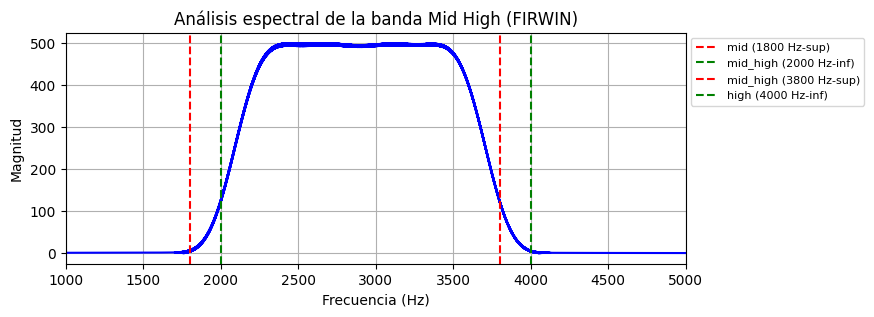

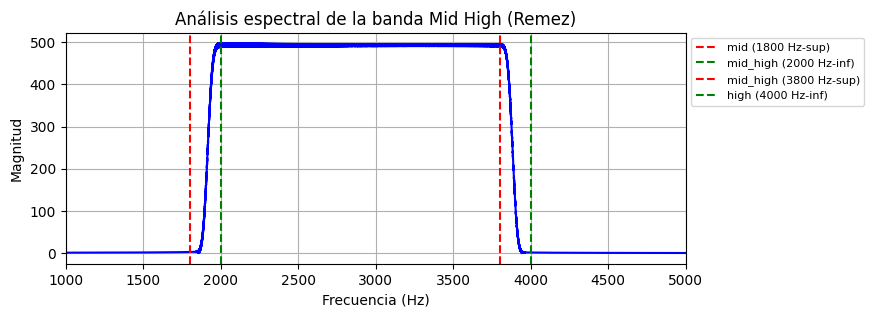

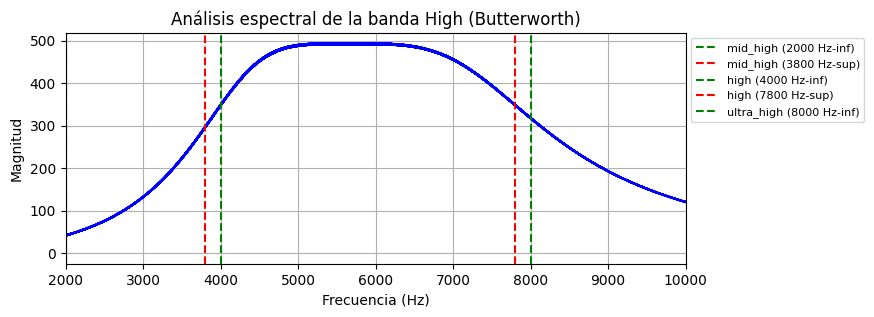

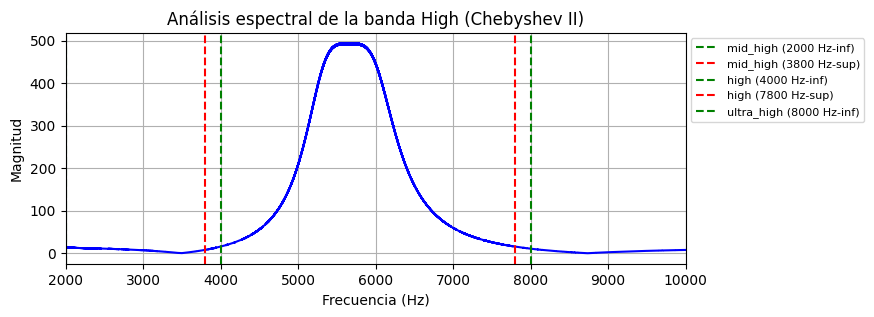

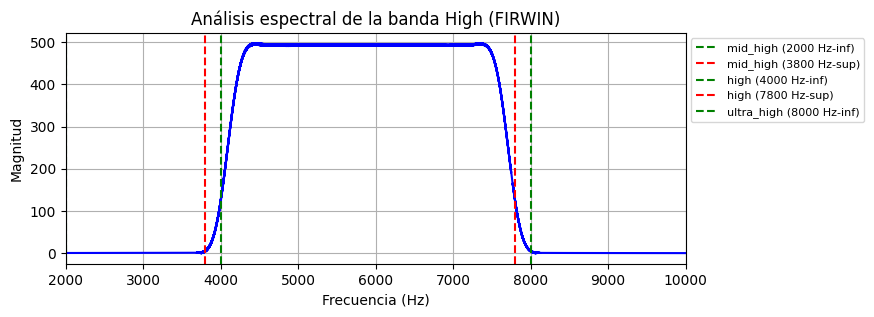

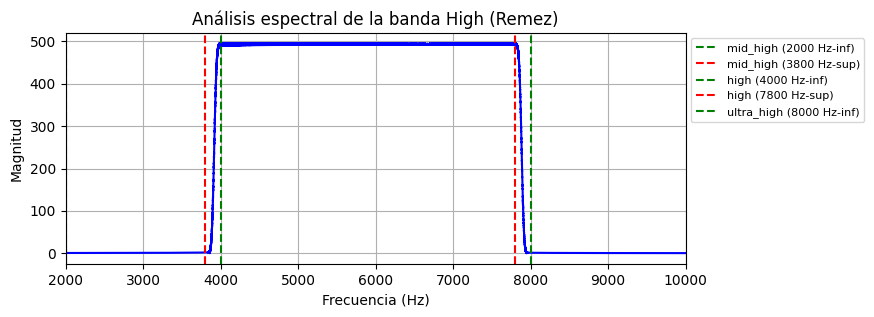

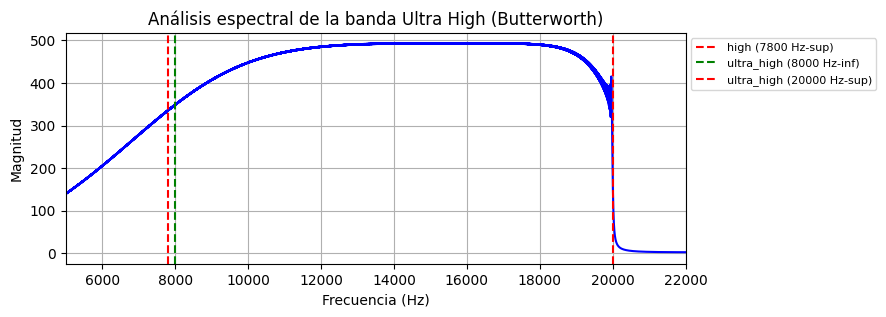

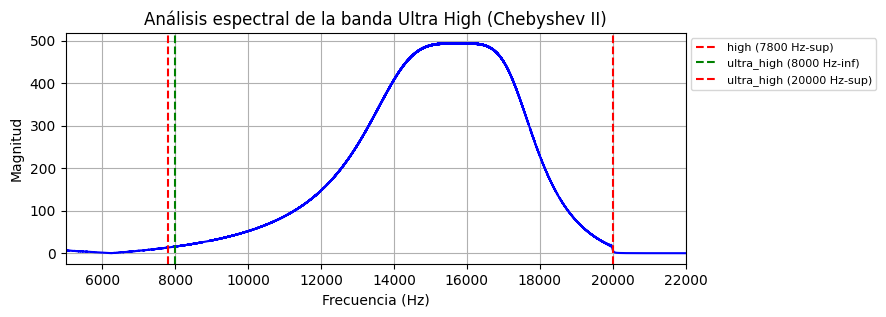

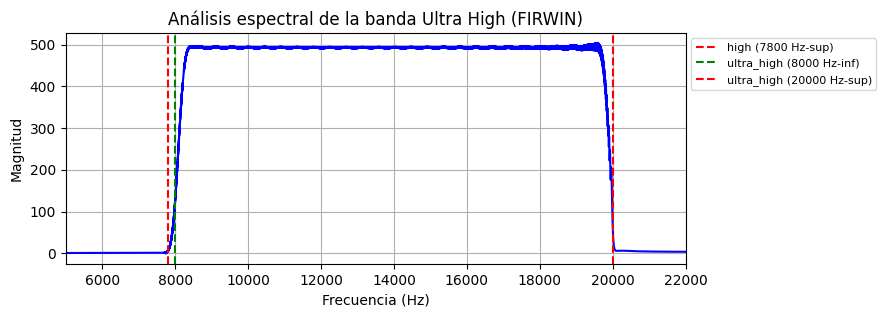

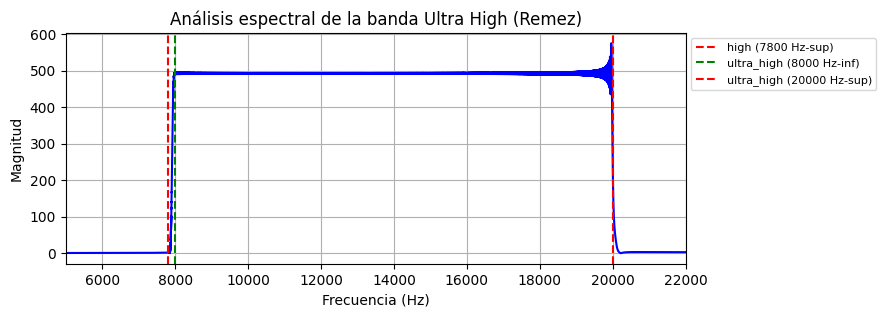

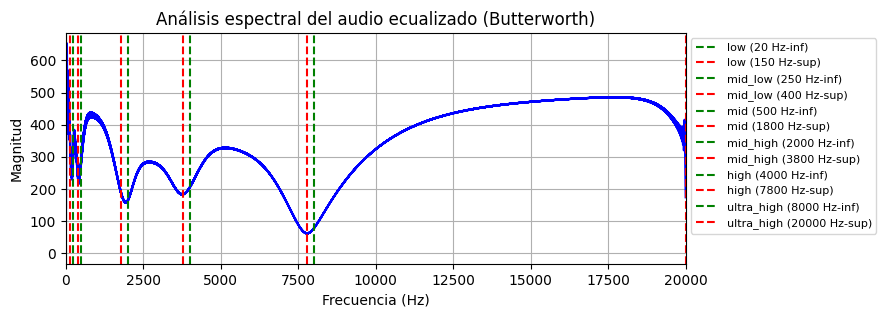

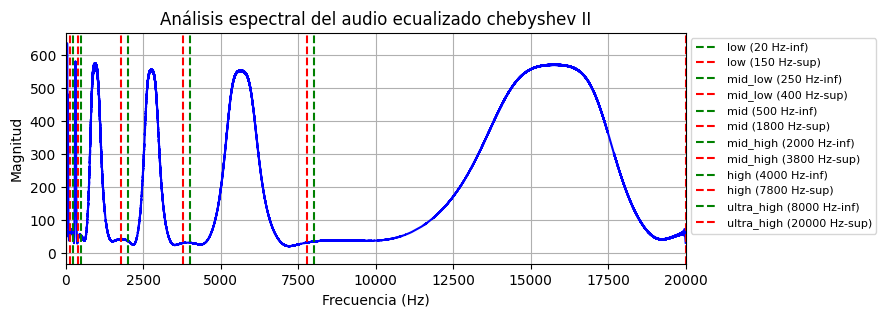

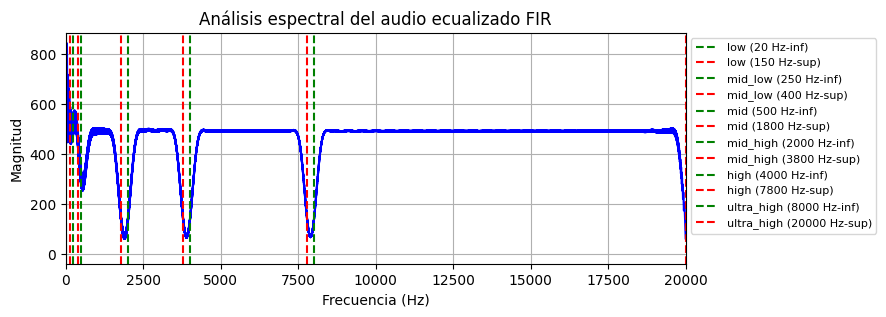

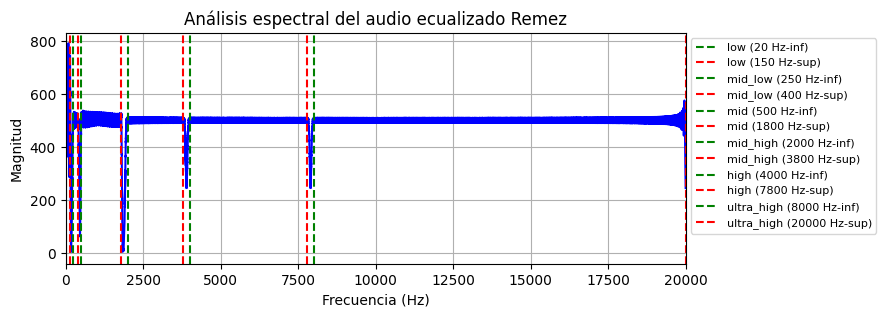

In [4]:
#from pydub import AudioSegment # Para utilizar archivos de audio
#from IPython.display import Audio # Reproducir audio en colab
#from scipy.io.wavfile import write # Guardar archivo en formato .wav
import numpy as np
from scipy.signal import chirp
from scipy.signal import butter, lfilter # Filtros digitales
#from pydub.playback import play # Reproducir en colab
import matplotlib.pyplot as plt
from scipy.signal import cheby2, freqz
from scipy.signal import firwin, filtfilt, remez

minsample = 2000
maxsample = minsample + 100

# Parámetros de la señal
duration = 10  # Duración en segundos
sample_rate = 44100  # Frecuencia de muestreo
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False) #base de tiempo

# Generar la señal de barrido de frecuencia (chirp)
start_freq = 1     # Frecuencia inicial en Hz
end_freq = 20000   # Frecuencia final en Hz
signal = chirp(t, f0=start_freq, f1=end_freq, t1=duration, method='linear')

# Visualizar la señal
plt.figure(figsize=(10, 4))
plt.plot(t, signal)
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Señal de barrido de frecuencia de 0 a 20 kHz")
plt.grid()
plt.show()

# Defino las frecuencias de corte para cada banda
bands = {
    "low": (20, 150),
    "mid_low": (250, 400),
    "mid": (500, 1800),
    "mid_high": (2000, 3800),
    "high": (4000, 7800),
    "ultra_high" : (8000, 20000)
}

# Ajustes de nivel para cada banda (por ejemplo, 0.5 para 50%)
band_levels = {
    "low": 1.0,
    "mid_low": 1.0,
    "mid": 1.0,
    "mid_high": 1.0,
    "high": 1.0,
    "ultra_high" : 1.0
}

# Diccionario para almacenar los resultados de cada banda
equalized_bands_butter = {}
equalized_bands_cheby2 = {}
equalized_bands_firwin = {}
equalized_bands_remez = {}

#Funcion para el ploteo del analisis espectral
def plot_spectral_analysis(signal, sample_rate, title="Análisis espectral", freq_range=None):

    x_min, x_max = freq_range
    # Calcular la Transformada de Fourier
    freqs = np.fft.fftfreq(len(signal), d=1/sample_rate)
    fft_magnitude = np.abs(np.fft.fft(signal))

    # Graficar solo la mitad positiva de las frecuencias
    half = len(freqs) // 2
    plt.figure(figsize=(8, 3))         #(12, 6))
    plt.plot(freqs[:half], fft_magnitude[:half], color="blue")
    plt.title(title)
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Magnitud")
    plt.grid()
    # Establecer el rango de frecuencia si se especifica
    if freq_range is not None:
        plt.xlim(freq_range)

    # Dibujar líneas verticales punteadas en las frecuencias de corte de cada banda
    if bands:
        for band, (low_cut, high_cut) in bands.items():
            if x_min <= low_cut <= x_max:  # Verifica si low_cut está dentro del rango
                plt.axvline(x=low_cut, color='g', linestyle='--', label=f'{band} ({low_cut} Hz-inf)')
            if x_min <= high_cut <= x_max:  # Verifica si high_cut está dentro del rango
                plt.axvline(x=high_cut, color='r', linestyle='--', label=f'{band} ({high_cut} Hz-sup)')


    plt.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))  # Posición fuera del gráfico

    # Evitar etiquetas duplicadas en la leyenda
    #handles, labels = plt.gca().get_legend_handles_labels()
    #unique_labels = dict(zip(labels, handles))
    #plt.legend(unique_labels.values(), unique_labels.keys())
    plt.show()

#Funciones para aplicar los filtros

def bandpass_filter_butter(data, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band') # b y a son los coeficientes del filtro
    return lfilter(b, a, data) # Aplica el filtro

def bandpass_filter_cheby2(data, lowcut, highcut, sample_rate, order=2, attenuation=30):
    nyquist = 0.5 * sample_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = cheby2(order, attenuation, [low, high], btype='band')
    return lfilter(b, a, data)

def bandpass_filter_firwin(data, lowcut, highcut, sample_rate, numtaps=200):
    nyquist = 0.5 * sample_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    taps = firwin(numtaps, [low, high], pass_zero=False)
    return filtfilt(taps, 1.0, data)  # filtfilt para evitar distorsión de fase

def bandpass_filter_remez(data, lowcut, highcut, sample_rate, numtaps=1500):

    #nyquist = sample_rate #0.5 * sample_rate
    #margen = lowcut*0.05
    #low = lowcut-margen
    #lowcut1=lowcut#/nyquist
    #highcut1=highcut#/nyquist
    #low = (lowcut-margen) #/ nyquist
    #high = (highcut+margen) # / nyquist

    if lowcut == 20:
      lowcut1=20
      highcut1=highcut
      low=lowcut-20
      high=highcut+20

    if lowcut == 250:
      lowcut1=250
      highcut1=highcut
      low=lowcut1 - 100
      high=highcut1+100

    if lowcut == 500:
      lowcut1=500
      highcut1=highcut
      low=lowcut1-50
      high=highcut1+50

    if lowcut == 2000:
      lowcut1=2000
      highcut1=highcut
      low=lowcut1-200
      high=highcut1+200

    if lowcut == 4000:
      lowcut1=4000
      highcut1=highcut
      low=lowcut1-200
      high=highcut1+200

    if lowcut == 8000:
      lowcut1=8000
      highcut1=highcut
      low=lowcut1-200
      high=highcut1+200

    # chequeo si la banda es valida
    if low >= high:
        raise ValueError("La banda de corte inferior debe ser inferior a la superior")
    #print("low: ", low)
    #print("high: ", high)
    #print("lowcut1: ",lowcut1)
    #print("highcut1: ",highcut1)

    taps = remez(numtaps, [0, low,lowcut1,highcut1,high, 0.5*sample_rate], [0, 1, 0],  fs=sample_rate, maxiter=50, grid_density=16)
    return filtfilt(taps, 1.0, data)


# Análisis espectral del archivo de audio original
plot_spectral_analysis(signal, sample_rate, title="Análisis espectral de la señal original", freq_range=(-500, 21000))

# Imprimo 100 valores del array de muestras
#print("Valores del array de audio sin normalizar y sin filtrar:")
#print(signal[minsample:maxsample])


#Aplico el filtro para cada banda
#Butterworth
for band, (lowcut, highcut) in bands.items():
    filtered_data_butter = bandpass_filter_butter(signal, lowcut, highcut, sample_rate)
    equalized_bands_butter[band] = filtered_data_butter * band_levels[band]
    #print("Valores por banda:")
    #print(band)
    #print(equalized_bands_butter[band][minsample:maxsample])

#Chebyshev Tipo II
for band, (lowcut, highcut) in bands.items():
    filtered_data_cheby2 = bandpass_filter_cheby2(signal, lowcut, highcut, sample_rate)
    equalized_bands_cheby2[band] = filtered_data_cheby2 * band_levels[band]
    #print("Valores por banda:")
    #print(band)
    #print(equalized_bands_cheby2[band][minsample:maxsample])

#Filtro FIR
for band, (lowcut, highcut) in bands.items():
    filtered_data_firwin = bandpass_filter_firwin(signal, lowcut, highcut, sample_rate)
    equalized_bands_firwin[band] = filtered_data_firwin * band_levels[band]
    #print("Valores por banda:")
    #print(band)
    #print(equalized_bands_firwin[band][minsample:maxsample])

#Filtro remez
for band, (lowcut, highcut) in bands.items():
    filtered_data_remez = bandpass_filter_remez(signal, lowcut, highcut, sample_rate)
    equalized_bands_remez[band] = filtered_data_remez * band_levels[band]



# Análisis espectral de cada banda
# banda low
plot_spectral_analysis(equalized_bands_butter["low"], sample_rate, title="Análisis espectral de la banda Low (Butterworth)", freq_range=(0, 250))
plot_spectral_analysis(equalized_bands_cheby2["low"], sample_rate, title="Análisis espectral de la banda Low (Chebyshev II)", freq_range=(0, 250))
plot_spectral_analysis(equalized_bands_firwin["low"], sample_rate, title="Análisis espectral de la banda Low (FIRWIN)", freq_range=(0, 250))
plot_spectral_analysis(equalized_bands_remez["low"], sample_rate, title="Análisis espectral de la banda Low (Remez)", freq_range=(0, 250))

# banda mid-low
plot_spectral_analysis(equalized_bands_butter["mid_low"], sample_rate, title="Análisis espectral de la banda Mid Low (Butterworth)", freq_range=(50, 800))
plot_spectral_analysis(equalized_bands_cheby2["mid_low"], sample_rate, title="Análisis espectral de la banda Mid Low (Chebyshev II)", freq_range=(50, 800))
plot_spectral_analysis(equalized_bands_firwin["mid_low"], sample_rate, title="Análisis espectral de la banda Mid Low (FIRWIN)", freq_range=(50, 800))
plot_spectral_analysis(equalized_bands_remez["mid_low"], sample_rate, title="Análisis espectral de la banda Mid Low (Remez)", freq_range=(50, 800))

# banda mid
plot_spectral_analysis(equalized_bands_butter["mid"], sample_rate, title="Análisis espectral de la banda Mid (Butterworth)", freq_range=(0, 2500))
plot_spectral_analysis(equalized_bands_cheby2["mid"], sample_rate, title="Análisis espectral de la banda Mid (Chebyshev II)", freq_range=(0, 2500))
plot_spectral_analysis(equalized_bands_firwin["mid"], sample_rate, title="Análisis espectral de la banda Mid (FIRWIN)", freq_range=(0, 2500))
plot_spectral_analysis(equalized_bands_remez["mid"], sample_rate, title="Análisis espectral de la banda Mid (Remez)", freq_range=(0, 2500))

# banda mid-high
plot_spectral_analysis(equalized_bands_butter["mid_high"], sample_rate, title="Análisis espectral de la banda Mid High (Butterworth)", freq_range=(1000, 5000))
plot_spectral_analysis(equalized_bands_cheby2["mid_high"], sample_rate, title="Análisis espectral de la banda Mid High (Chebyshev II)", freq_range=(1000, 5000))
plot_spectral_analysis(equalized_bands_firwin["mid_high"], sample_rate, title="Análisis espectral de la banda Mid High (FIRWIN)", freq_range=(1000, 5000))
plot_spectral_analysis(equalized_bands_remez["mid_high"], sample_rate, title="Análisis espectral de la banda Mid High (Remez)", freq_range=(1000, 5000))

# banda high
plot_spectral_analysis(equalized_bands_butter["high"], sample_rate, title="Análisis espectral de la banda High (Butterworth)", freq_range=(2000, 10000))
plot_spectral_analysis(equalized_bands_cheby2["high"], sample_rate, title="Análisis espectral de la banda High (Chebyshev II)", freq_range=(2000, 10000))
plot_spectral_analysis(equalized_bands_firwin["high"], sample_rate, title="Análisis espectral de la banda High (FIRWIN)", freq_range=(2000, 10000))
plot_spectral_analysis(equalized_bands_remez["high"], sample_rate, title="Análisis espectral de la banda High (Remez)", freq_range=(2000, 10000))

# banda ultra-high
plot_spectral_analysis(equalized_bands_butter["ultra_high"], sample_rate, title="Análisis espectral de la banda Ultra High (Butterworth)", freq_range=(5000, 22000))
plot_spectral_analysis(equalized_bands_cheby2["ultra_high"], sample_rate, title="Análisis espectral de la banda Ultra High (Chebyshev II)", freq_range=(5000, 22000))
plot_spectral_analysis(equalized_bands_firwin["ultra_high"], sample_rate, title="Análisis espectral de la banda Ultra High (FIRWIN)", freq_range=(5000, 22000))
plot_spectral_analysis(equalized_bands_remez["ultra_high"], sample_rate, title="Análisis espectral de la banda Ultra High (Remez)", freq_range=(5000, 22000))


# Sumar las bandas para obtener el audio ecualizado
equalized_signal_butter = sum(equalized_bands_butter.values())
#print("Valores sumados:")
#print(equalized_signal_butter[minsample:maxsample])

equalized_signal_cheby2 = sum(equalized_bands_cheby2.values())
#print("Valores sumados:")
#print(equalized_signal_cheby2[minsample:maxsample])

equalized_signal_firwin = sum(equalized_bands_firwin.values())
#print("Valores sumados:")
#print(equalized_signal_firwin[minsample:maxsample])

equalized_signal_remez = sum(equalized_bands_remez.values())
#print("Valores sumados:")
#print(equalized_signal_remez[minsample:maxsample])

# Análisis espectral del audio ecualizado completo con rango de 0 a 20 kHz
plot_spectral_analysis(equalized_signal_butter, sample_rate, title="Análisis espectral del audio ecualizado (Butterworth)", freq_range=(0, 20000))

plot_spectral_analysis(equalized_signal_cheby2, sample_rate, title="Análisis espectral del audio ecualizado chebyshev II", freq_range=(0, 20000))

plot_spectral_analysis(equalized_signal_firwin, sample_rate, title="Análisis espectral del audio ecualizado FIR", freq_range=(0, 20000))

plot_spectral_analysis(equalized_signal_remez, sample_rate, title="Análisis espectral del audio ecualizado Remez", freq_range=(0, 20000))
